In [21]:
! pip install openai==0.28

In [26]:
import pandas as pd
import openai
from time import strftime
import matplotlib.pyplot as plt
import numpy as np

In [84]:
def prompt(Q):
  tries = 0
  while tries<5:
    try:
      response = openai.ChatCompletion.create(
        model=mmodel,
        messages=Q,
        temperature=0.5,
        #max_tokens=tkn,
        frequency_penalty=0,
        presence_penalty=0,
        request_timeout=199
      )['choices'][0]['message']['content']
      break
    except Exception as e:
      tries = tries+1
      print(f"An error occurred {tries:d}th time: {e}")
  return(Q,response)

In [14]:
mmodel = "gpt-3.5-turbo-1106"
openai.api_key = "YOUR_API_KEY"

In [116]:
PROPERTY = 'Yield strength'

system = 'I will first train you. You follow instructions carefully, you provide as many rows of the table as possible. At least 20 rows each prompt.'

qs = ["Provide me with a list of "+PROPERTY+" values for different high entropy alloys materials. Your response should be a table consisting of 2 columns: material, value. The materials have to be typed as unique chemical compositions consisting of chemical element abbreviations and numbers only (e.g. GaAs, but not Gallium Arsenide). The values have to be single numbers, not ranges. Type out as many different values as you can. You are not allowed to type anything else than this table.",
      "Continue expanding this table with new values of "+PROPERTY+" making sure you do not duplicate entries. Type out as many different values as you can. You are not allowed to type anything else than this table."]


In [124]:
dtime = strftime("%Y_%m_%d-%H%M%S")
filename = PROPERTY.replace(" ", "")+'_'+dtime+'.csv'
print(f"Saving to: {filename} and {filename.replace('csv','txt')}")

Saving to: Yieldstrength_2024_04_14-142107.csv and Yieldstrength_2024_04_14-142107.txt


In [125]:
sss = [{"role": "system", "content": system}]
tab = []
tab_clean = []
ur = 0
um = 0
i = 0

In [98]:
# load GTD
gtd_df = pd.read_csv('yield_strength_GTD.csv')
gtd_df

,material,value,passage
0,Alloy 82/182,420.0,Chapter 12 Engineering Applications. Overall t...
1,CoNiFe(AlSi)0.2,342.0,2 High-entropy alloys: basic concepts. In the ...
2,HEA,1262.0,6 Synthesis and processing. The SPSed alloy ha...
3,SWCed,630.0,6 Synthesis and processing. The relative densi...
4,HEA,315.0,6 Synthesis and processing. The FSP of HEA ref...
...,...,...,...
8789,CoCrFeMnNi (0 at.%% Mo),216.0,Improved tribological performance of nickel ba...
8790,5 wt% TiC-reinforced HEA,698.0,Effect of ZrO2 particles on the nanomechanical...
8791,Al0.3CoCrFeMnNi-3 vol% Y2O3,1760.0,Effect of ZrO2 particles on the nanomechanical...
8792,Al0.3CoCrFeMnNi-0 vol% Y2O3,980.0,Effect of ZrO2 particles on the nanomechanical...


In [126]:
table = str(gtd_df[['material', 'value']].head(50).astype(str))
while True:
  if i< 1:
    qq = "Read the following table, it contants the true yield strength values of different materials" + table + "next, you give me a list of materials' yield strength that are not in this table"
  elif i == 1:
    qq = qs[0]
  else:
    qq = qs[1]

  sss.append({"role": "user", "content": qq})
  sss,ans = prompt(sss)
  sss.append({"role": "assistant", "content": ans})

  with open(filename.replace('csv','txt'), 'a') as file:
    print("USER: "+qq, file=file)
    print("GPT : "+ans, file=file)

  if i >= 1:
    lines = ans.split('\n')
    if 'value' in lines[0].lower():
      ans = '\n'.join(lines[1:])
    lines = ans.split('\n')
    if '----' in lines[0].lower():
      ans = '\n'.join(lines[1:])
    lines = ans.split('\n')

    tab.append(ans)
    try:
      for line in tab[-1].strip().split('\n'):
        tab_clean.append(line.strip('|').split('|'))
    except:
      pass

    df = pd.DataFrame(tab_clean, columns=['Material', 'Value'])
    df = df[pd.to_numeric(df['Value'], errors='coerce').notna()]
    df['Value'] = pd.to_numeric(df['Value'])
    df.to_csv(filename, index=False)

    # here I count how many new (non-duplicate) materials we are extracting each
    # time, to monitor progress. We stop if more than 10 iterations or not progress
    if len(df.drop_duplicates()) > ur or df['Material'].nunique() > um:
      ur = len(df.drop_duplicates())
      um = df['Material'].nunique()
      i = i+1
      if i > 10 + 1:
        print("Stopping due to 10 iterations exceeded")
        break
    else:
      print("Stopping due to NO PROGRESS")
      break

    print(f"Iteration: {i:3} Generated_rows: {len(lines):3};     TOTAL:  Uniq_rows: {len(df.drop_duplicates()):4d}   Uniq_materials: {df['Material'].nunique():4d}")
  else:
    i += 1

print(df)

Iteration:   2 Generated_rows:  42;     TOTAL:  Uniq_rows:   42   Uniq_materials:   40
Iteration:   3 Generated_rows:  52;     TOTAL:  Uniq_rows:   52   Uniq_materials:   50
Iteration:   4 Generated_rows:  61;     TOTAL:  Uniq_rows:   61   Uniq_materials:   59
Stopping due to NO PROGRESS
              Material   Value
0     CoNiFe(AlSi)0.2    342.0
1         HEA           1262.0
2         SWCed          630.0
3         HEA            315.0
4         CTCRed HEA    1500.0
..                 ...     ...
150      CoCrFeNiV       900.0
151      CoCrFeNiNb      870.0
152      CoCrFeNiMo      840.0
153      CoCrFeNiW       810.0
154      CoCrFeNiHf      780.0

[155 rows x 2 columns]


In [139]:
check_list = list(df['Material'])
gen_value = list(df['Value'])
gtd_list = list(gtd_df['material'])
gtd_value = list(gtd_df['value'])

err = []
for m in check_list:
    if m.strip() in gtd_list:
        val = gen_value[check_list.index(m)]
        cor = gtd_value[gtd_list.index(m.strip())]
        err.append(abs(val - cor) / cor)
    else:
        material = m.strip()
        found = False
        for gtd in gtd_list:
            if material in gtd:
                prev_idx = gtd.index(material) - 1
                next_idx = gtd.index(material) + len(material)
                if prev_idx > 0 and (gtd[prev_idx].isalpha() or gtd[prev_idx].isdigit()):
                    continue
                if next_idx < len(gtd) and (gtd[next_idx].isalpha() or gtd[next_idx].isdigit()):
                    continue 
                val = gen_value[check_list.index(m)]
                cor = gtd_value[gtd_list.index(gtd)]
                err.append(abs(val - cor) / cor)
                found = True
                break
        if not found:
            err.append(-1)

print("Total:", len(check_list))
print("Found:", len(err) - err.count(-1))
print("Unkdown:", err.count(-1))
cor = [x for x in err if x <= 0.1]
print("# of correct:", len(cor))
for i in range(len(err)):
    if err[i] == -1:
        err[i] = None
filtered_list = list(result_df[result_df['precentage of error'] >= 0.0]['precentage of error'])
print("average error:", sum(filtered_list) / len(filtered_list))
result_df = pd.DataFrame({
    "Material": check_list,
    "precentage of error": err
})
result_df

Total: 155
Found: 141
Unkdown: 14
# of correct: 139
average error: 0.12071430979533282


,Material,precentage of error
0,CoNiFe(AlSi)0.2,0.000000
1,HEA,0.000000
2,SWCed,0.000000
3,HEA,0.000000
4,CTCRed HEA,0.000000
...,...,...
150,CoCrFeNiV,0.264045
151,CoCrFeNiNb,0.621739
152,CoCrFeNiMo,0.220930
153,CoCrFeNiW,NaN


In [137]:
result_df[result_df['precentage of error'] > 0.0]

,Material,precentage of error
31,MoNbTaW,0.617202
73,MoNbTaW,0.617202
85,AlCoCrFeNi,0.056000
86,CoCrFeNiPd,1.865854
87,CoCrFeNiMn,0.154412
88,CoCrFeNiCu,3.956522
89,CoCrFeNiTi,0.577358
90,CoCrFeNiAl,0.421053
125,MoNbTaW,0.617202
137,AlCoCrFeNi,0.056000


Text(0, 0.5, 'Frequency')

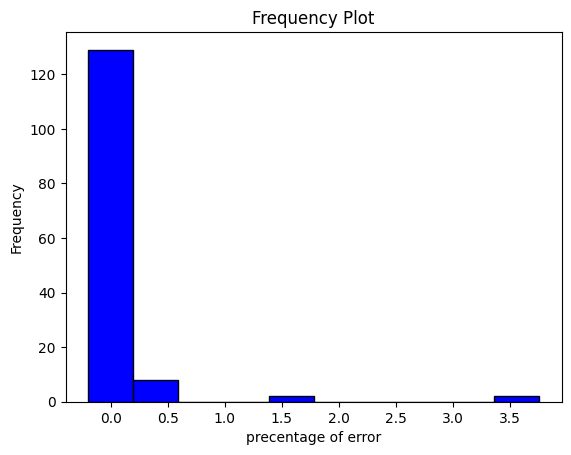

In [128]:
data = list(result_df["precentage of error"])
plt.hist(data, align='left', color='blue', edgecolor='black')
plt.title('Frequency Plot')
plt.xlabel('precentage of error')
plt.ylabel('Frequency')